In [1]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
pd.set_option('display.max_colwidth', None)
import glob
import datetime
from config_loader import (
    D_CONFIG, DATASET_TOP_PATH,
    DATASET_SITE_PATH, PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    DATASET_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH,
    RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH
    )

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
from feature_transformation import *
from utils import load_data_dict_json
deployment_code_dir = os.path.join('/home', 'prash', 'clinical_deterioration')
sys.path.append(deployment_code_dir)
sys.path.append(os.path.join(deployment_code_dir, 'src_code'))
sys.path.append(os.path.join(deployment_code_dir, 'data_example'))
sys.path.append(os.path.join(deployment_code_dir, 'src_code', 'utils_specs'))
import onnxruntime as rt

# RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH = os.path.join(RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH, 'sklearn_logistic_regression')
# CLF_TRAIN_TEST_SPLIT_PATH=os.path.join(DATASET_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH, 'classifier_train_test_split')

In [2]:
CLF_TRAIN_TEST_SPLIT_PATH = '/home/prash/datasets/v20210909/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split'
MODEL_PATH = '/home/prash/results/madrid/v20210909/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/'
model_onnx_file = glob.glob(os.path.join(MODEL_PATH, '*min_samples_per_leaf=1024-max_leaves=8-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33*.onnx'))[0]

## Load the raw data as well as featurized data for a test participant

In [3]:
collapsed_features_dd = load_data_dict_json(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'Spec_features.json'))
collapsed_features = parse_feature_cols(collapsed_features_dd)
x_test_df = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'x_test.csv.gz'), nrows=10000)
y_test_df = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.csv.gz'), nrows=10000)


select_hadm_id = 15292953
x_test_df = x_test_df.query('hospital_admission_id == %d'%select_hadm_id).reset_index(drop=True)
y_test_df = y_test_df.query('hospital_admission_id == %d'%select_hadm_id).reset_index(drop=True)
pred_times = x_test_df['stop'].values

x_test = x_test_df[collapsed_features].values.astype(np.float32)
y_test = y_test_df['clinical_deterioration_outcome'].astype(int)

stay_length = y_test_df.stay_length.values[0]

sess = rt.InferenceSession(model_onnx_file)
input_name = sess.get_inputs()[0].name
proba_label_name = sess.get_outputs()[1].name    

thresh = 0.88
y_test_probas_list_of_dicts = sess.run([proba_label_name], {input_name: x_test.astype(np.float32)})[0]
y_test_proba_vals = np.asarray([i[1] for i in y_test_probas_list_of_dicts])
y_test_preds = y_test_proba_vals>=thresh

## Load the raw features for this subject

In [4]:
vitals_df = pd.read_csv(os.path.join(DATASET_SITE_PATH, 'vitals_before_icu.csv.gz'), nrows=500000)
vitals_df = vitals_df.query('hospital_admission_id == %d'%select_hadm_id).reset_index(drop=True)

labs_df = pd.read_csv(os.path.join(DATASET_SITE_PATH, 'labs_before_icu.csv.gz'), nrows=500000)
labs_df = labs_df.query('hospital_admission_id == %d'%select_hadm_id).reset_index(drop=True)


demographics_dd = load_data_dict_json(os.path.join(DATASET_SITE_PATH,
                                                  'Spec-Demographics.json'))
vitals_dd = load_data_dict_json(os.path.join(DATASET_SITE_PATH,
                                                  'Spec-Vitals.json'))
labs_dd = load_data_dict_json(os.path.join(DATASET_SITE_PATH,
                                                  'Spec-Labs.json'))

vital_cols = parse_feature_cols(vitals_dd)
lab_cols = parse_feature_cols(labs_dd)
demographic_cols = parse_feature_cols(demographics_dd)
id_cols = parse_id_cols(vitals_dd)
time_col = parse_time_cols(vitals_dd)[-1]

## Make predictions with Vitals only

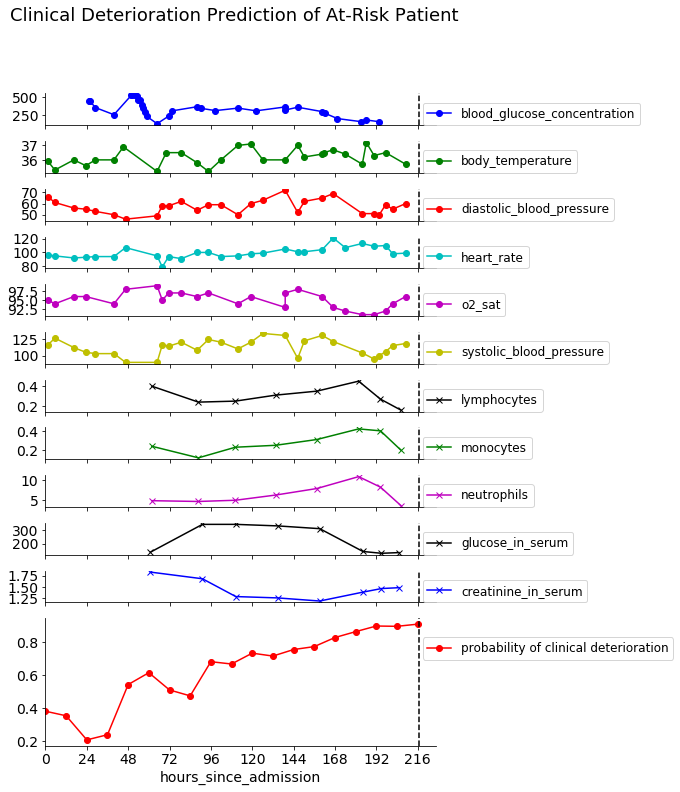

In [9]:
exclude_cols = ['bmi', 'height', 'weight', 'respiratory_rate']
fontsize=14

plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'g', 'm', 'k', 'b']
plot_cols = [col for col in vital_cols if col not in exclude_cols]

plot_cols = plot_cols + ['lymphocytes', 'monocytes', 'neutrophils', 'glucose_in_serum', 'creatinine_in_serum']

height_ratios=list(np.ones(len(plot_cols)+1))
gridspec = {'hspace': 0.4, 'height_ratios': height_ratios}
height_ratios[-1] = 4
f, axs = plt.subplots(nrows=len(plot_cols)+1, ncols=1, figsize=(7, 12), sharex=True, gridspec_kw=gridspec)


for vv, vital in enumerate(plot_cols) :
    
    try:
        t_by_var = vitals_df[time_col].values
        v_by_var = vitals_df[vital].values
        marker = '-o'
    except:
        t_by_var = labs_df[time_col].values
        v_by_var = labs_df[vital].values
        marker = '-x'
    
    mask = np.logical_not(np.isnan(v_by_var))
    t_by_var = t_by_var[mask]
    v_by_var = v_by_var[mask]
    
    axs[vv].plot(t_by_var, v_by_var,marker, color=plot_colors[vv], label=vital)
#     axs[vv].legend(bbox_to_anchor = (1.0, 1.0))
#     axs[vv].spines['right'].set_visible(False)
#     axs[vv].spines['top'].set_visible(False)

axs[-1].plot(pred_times, y_test_proba_vals, 'r-o', label='probability of clinical deterioration')
axs[-1].set_xlabel('hours_since_admission', fontsize=fontsize)
# axs[6].legend(bbox_to_anchor = (1.0, 1.0))
# axs[0].legend(bbox_to_anchor = (1.0, 1.0))
# ticks = axs[6].get_xticks()
# dic = {stay_length : "transfer to ICU"}
# labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
# axs[6].set_xticklabels(labels)

for ax in axs:
    ax.set_xticks(np.arange(0, stay_length, 24))
    ax.axvline(stay_length, color='k',linestyle="--")
    ax.set_xlim([0, stay_length+10])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
    ax.legend(bbox_to_anchor = (0.95, 0.9), fontsize=fontsize-2)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    
plt.suptitle('Clinical Deterioration Prediction of At-Risk Patient', fontsize=fontsize+4)

f.savefig('motivation_clinical_deterioration_prediction', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'Clinical Deterioration Prediction of At-Risk Patient')

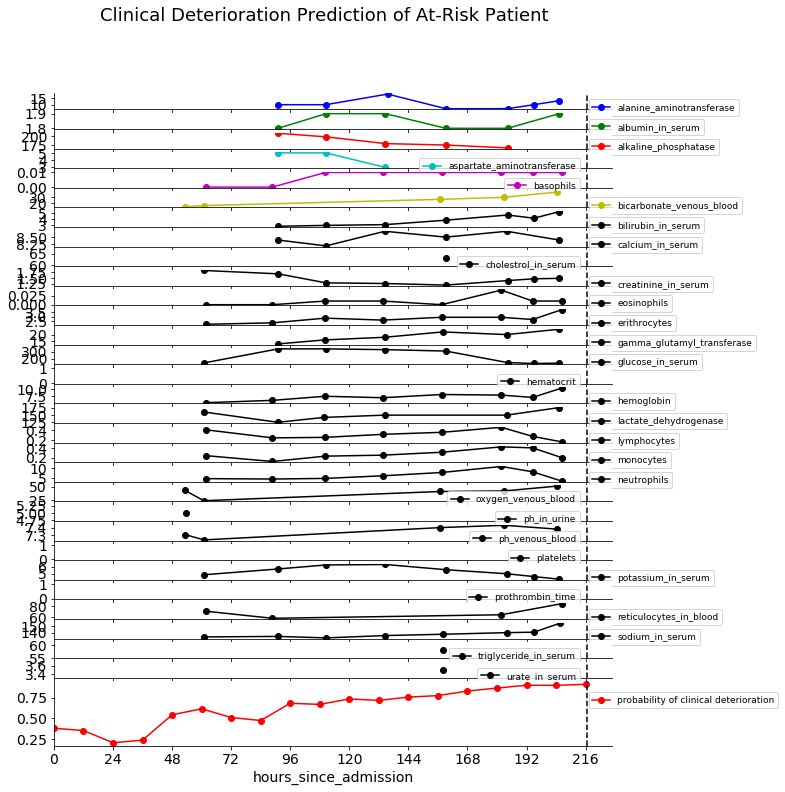

In [153]:
exclude_cols = ['bmi', 'height', 'weight', 'respiratory_rate']
fontsize=14

plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plot_cols = [col for col in lab_cols if col not in exclude_cols]

height_ratios=list(np.ones(len(plot_cols)+1))
gridspec = {'hspace': 0.2, 'height_ratios': height_ratios}
height_ratios[-1] = 4
f, axs = plt.subplots(nrows=len(plot_cols)+1, ncols=1, figsize=(10, 12), sharex=True, gridspec_kw=gridspec)


for vv, lab in enumerate(plot_cols) :
    t_by_var = labs_df[time_col].values
    v_by_var = labs_df[lab].values
    
    mask = np.logical_not(np.isnan(v_by_var))
    t_by_var = t_by_var[mask]
    v_by_var = v_by_var[mask]
    try:
        axs[vv].plot(t_by_var, v_by_var,'-o', color=plot_colors[vv], label=lab)
    except:
        axs[vv].plot(t_by_var, v_by_var,'-o', color='k', label=lab)
#     axs[vv].legend(bbox_to_anchor = (1.0, 1.0))
#     axs[vv].spines['right'].set_visible(False)
#     axs[vv].spines['top'].set_visible(False)

axs[-1].plot(pred_times, y_test_proba_vals, 'r-o', label='probability of clinical deterioration')
axs[-1].set_xlabel('hours_since_admission', fontsize=fontsize)
# axs[6].legend(bbox_to_anchor = (1.0, 1.0))
# axs[0].legend(bbox_to_anchor = (1.0, 1.0))
# ticks = axs[6].get_xticks()
# dic = {stay_length : "transfer to ICU"}
# labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
# axs[6].set_xticklabels(labels)

for ax in axs:
    ax.set_xticks(np.arange(0, stay_length, 24))
    ax.axvline(stay_length, color='k',linestyle="--")
    ax.set_xlim([0, stay_length+10])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor = (0.95, 0.9), fontsize=fontsize-5)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    
plt.suptitle('Clinical Deterioration Prediction of At-Risk Patient', fontsize=fontsize+4)


In [148]:
gridspec

{'hspace': 0.2, 'height_ratios': [1, 1, 1, 1, 1, 1, 4]}